# Rambling Exploration of Auto Diff and NN Training

Inspired by https://youtu.be/VMj-3S1tku0?si=evpoOT5i5Kx8vpeE though initially too impatient to watch the actual video

In [2]:
%pip install numpy
%pip install matplotlib
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
%matplotlib inline

# A Derivative

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

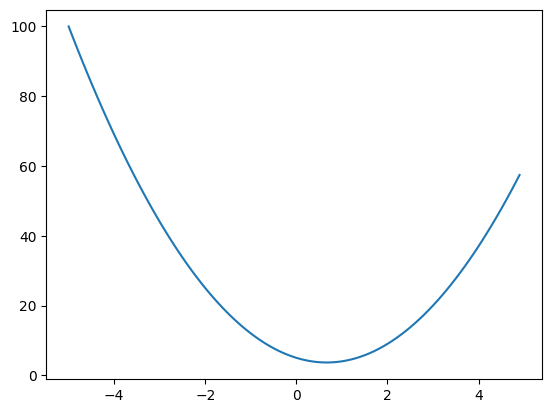

In [5]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.001
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

In [7]:
6 * x - 4 # the analytical derivative

14.0

# Simple Autograd

Start defining the nodes of the DAG for a calculation, including labels for the nodes

In [8]:
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0 # ignore this for now - will add later

    def __repr__(self) -> str:
        return f"Value(label={self.label}, data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
print(L)
print(L._prev)
print(L._op)

Value(label=L, data=-8.0)
(Value(label=d, data=4.0), Value(label=f, data=-2.0))
*


Set up some tooling to visualize the DAG

In [9]:
from graphviz import Digraph

def trace(root: Value) -> tuple[set[Value], set[Value]]:
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f} " % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

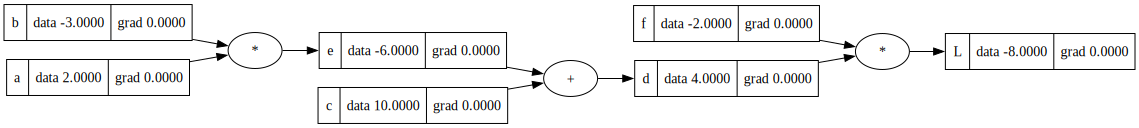

In [10]:
draw_dot(L)

We now want to be able to take a calculation result node and be able to calculate dx/dL for each preceeding node. When doing backprop, some of these preceeding nodes will be weights and we'll use the gradient of L relative to the weight to improve its value.

To do this we want to introduce a `grad` property. We can use the chain rule that for a node, x, dx/dL = dx/dP * dP/dL where, in this case, P will be parent or downstream node.

In [11]:
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 1.0

    def __repr__(self) -> str:
        return f"Value(label={self.label}, data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def backprop(self):
        if self._op == '*':
            self._prev[0].grad = self._prev[1].data * self.grad
            self._prev[1].grad = self._prev[0].data * self.grad
            for child in self._prev:
                child.backprop()
        elif self._op == '+':
            self._prev[0].grad = 1.0 * self.grad
            self._prev[1].grad = 1.0 * self.grad
            for child in self._prev:
                child.backprop()
        else:
            return
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
print(L)
print(L._prev)
print(L._op)

Value(label=L, data=-8.0)
(Value(label=d, data=4.0), Value(label=f, data=-2.0))
*


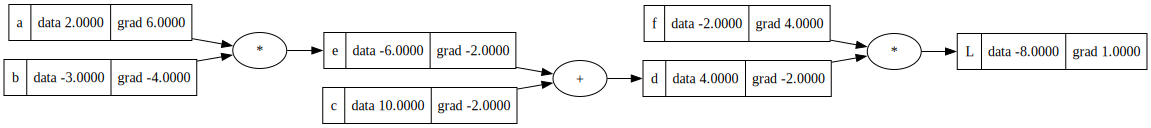

In [12]:
L.backprop()
# Lets see the gradients
draw_dot(L)

In [13]:
# A quick numerical check to see if da/dL matches our backprop
def local_scope():
    h = 0.00001
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    f = Value(-2.0, label='f')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    L1 = d * f; L.label = 'L'

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    f = Value(-2.0, label='f')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    L2 = d * f; L.label = 'L'

    gradient = (L1.data - L2.data) / h
    print(gradient)
local_scope()

6.000000000128124


In [14]:
# We can now use the gradients

print(a.grad)
print(b.grad)
print(c.grad)

6.0
-4.0
-2.0


# A simple NN

In [15]:
import random

In [16]:
def rand_vec(size):
    return [random.uniform(-1, 1) for _ in range(size)]

In [17]:
def relu(v):
    return v if v > 0 else 0

class Perceptron:

    def __init__(self, weights, activation_fn='relu'):
        self.weights = weights
        self.acivation_fn = activation_fn

    def __repr__(self) -> str:
        return f"Perceptron({self.weights}, activation_fn={self.acivation_fn})"

    def forward(self, inputs):
        if (len(inputs) != len(self.weights)):
            raise Exception("Number of inputs must match number of weights")
        result = sum(w*v for w, v in zip(self.weights, inputs))
        if (self.acivation_fn == 'relu'):
            result = relu(result)
        return result

In [18]:
eg_node = Perceptron(rand_vec(5))
print(eg_node)
print(eg_node.forward(rand_vec(5)))

Perceptron([0.3876217107095079, 0.7836778719371509, -0.9149339381814625, 0.04810437693104164, -0.3887075515206606], activation_fn=relu)
0.49447071907411616


In [19]:
class Layer:

    def __init__(self, input_size, num_node):
        self.input_size = input_size
        self.nodes = [Perceptron(rand_vec(input_size)) for _ in range(num_node)]

    def __repr__(self) -> str:
        return f"Layer(input_size={self.input_size}, num_node={len(self.nodes)})"

    def forward(self, inputs):
        if (len(inputs) != self.input_size):
            raise Exception("Number of inputs doesn't match layer expectation")
        return [node.forward(inputs) for node in self.nodes]

In [20]:
eg_layer = Layer(5, 10)
print(eg_layer)
print(eg_layer.forward(rand_vec(eg_layer.input_size)))

Layer(input_size=5, num_node=10)
[0, 0, 1.1954827736803493, 0.15999029523764052, 1.5013807726655553, 0, 1.4557432356171864, 0, 0.9959476096258685, 1.331961585102969]


In [21]:
class FinalLayer:
    def __init__(self, input_size) -> None:
        self.input_size = input_size
        self.node = Perceptron(rand_vec(input_size), '')

    def __repr__(self) -> str:
        return f"FinalLayer(input_size={self.input_size})"

    def forward(self, inputs):
        if (len(inputs) != self.input_size):
            raise Exception("Number of inputs doesn't match layer expectation")
        return self.node.forward(inputs)


In [22]:
eg_final_layer = FinalLayer(10)
print(eg_final_layer)
print(eg_final_layer.forward(rand_vec(eg_final_layer.input_size)))

FinalLayer(input_size=10)
0.35739983964329486


In [23]:
# a two layer forward pass
inputs = rand_vec(eg_layer.input_size)
l1_act = eg_layer.forward(inputs)
l2_act = eg_final_layer.forward(l1_act)
print(inputs)
print(l1_act)
print(l2_act)

[-0.03941159707548314, -0.6816998179215472, -0.1943008070727943, 0.6039342208197647, 0.6290214915847381]
[0, 0, 0, 0.5275355594881801, 0.506176840307848, 0, 0.2026960706126929, 0.3280848808663046, 0, 0]
0.1868561627589506


In [24]:
class SimpleNN:
    def __init__(self, input_size: int, layer_sizes: list[int]) -> None:
        self.input_size = input_size
        self.layers: list[Layer] = []
        last_layer_size = input_size
        for i in range(len(layer_sizes)):
            self.layers.append(Layer(last_layer_size, layer_sizes[i]))
            last_layer_size = layer_sizes[i]
        self.layers.append(FinalLayer(last_layer_size))

    def __repr__(self) -> str:
        return f"SimpleNN(input_size={self.input_size}, num_layers={len(self.layers)})"
    
    def forward(self, inputs):
        result = inputs
        for layer in self.layers:
            result = layer.forward(result)
        return result

In [25]:
def local_scope():
    nn = SimpleNN(5, [5, 10])
    print(inputs)
    print(nn.layers[0].forward(inputs))
    print(nn.layers[1].forward(nn.layers[0].forward(inputs)))
    print(nn.layers[2].forward(nn.layers[1].forward(nn.layers[0].forward(inputs))))
    print(nn.forward(inputs))
local_scope()

[-0.03941159707548314, -0.6816998179215472, -0.1943008070727943, 0.6039342208197647, 0.6290214915847381]
[0, 0, 0, 1.1023712613620484, 0]
[0, 0.2553603811063857, 0.7908561640584559, 0.26203017344481444, 0, 0, 0, 0, 0.16414515136786806, 0]
-0.5761360564576194
-0.5761360564576194


But what does our NN even do? Well nothing yet since it hasn't been trained to do anything.

How do we train it? We need some data. Some examples of input/output pairs that we want the NN to emulate.

Lets try to get the NN to do something that we know how to do well and can artifically generate a lot of data for easily. Like adding up the inputs.

In [26]:
adder_nn = SimpleNN(5, [10, 10])

In [27]:
training_data_size = 1000
training_data = [rand_vec(5) for i in range(training_data_size)]
training_data = [(x, sum(x)) for x in training_data]
print(training_data[0])
print(sum(training_data[0][0]))

([0.3249633352279908, -0.33305017225530364, 0.5274264203627885, -0.40422949905377004, -0.845303874916209], -0.7301937906345033)
-0.7301937906345033


In [28]:
def init_loss(nn: SimpleNN, example):
    return (nn.forward(example[0]) - example[1])**2

def test(nn: SimpleNN, examples):
    return sum([init_loss(nn, example) for example in examples]) / len(examples)

In [29]:
def local_scope():
    example = [[1, 1, 1, 1, 1], 5]
    print(adder_nn.forward(example[0]))
    print(test(adder_nn, [example]))
local_scope()

1.37246946638496
13.158977772309418


In [30]:
test(adder_nn, training_data)

1.9026860234974203

# Dave's Janky Optimiser (turns out to be shit)

So we can now calculate our loss, $L$, for a particular example. We just need to use that to update our weights. This is where stochastic gradient descent comes in.

First we'll need to be able to get, for any weight in any layer, the partial derivative of the loss with respect to that weight for the particular input/output $\frac{\partial L}{\partial w_l,i}$ for weight $i$ in layer $l$.

Changing $w_{l,i}$ by $\Delta w$ changes $L$ by approx $\frac{\partial L}{\partial w_{l,i}} * \Delta w$ so if we set $\Delta w = -L / \frac{\partial L}{\partial w_{l,i}}$ then we approximately remove the error :D

In practise people remove a fraction of that value since there are a lot of moving parts and I assume this works better. We'll experiment and see

In [31]:
# define the weight update fn, aka the optimiser. We'll still need the gradient though
def updated_weight(weight, gradient, loss):
    return weight - loss / gradient

target_w=3
init_w=1.0
init_loss=324.0
grad=-1026.0
new_w(0)=1.3157894736842106
grad=-974.8421052631579
new_w(1)=1.551480742673009
grad=-936.6601196869725
new_w(2)=1.7329284712294637
grad=-907.2655876608269
new_w(3)=1.8762636673939947
grad=-884.0452858821728
new_w(4)=1.9919652639028813
grad=-865.3016272477332
new_w(5)=2.0870845307246055
grad=-849.8923060226139
new_w(6)=2.1665141084476343
grad=-837.0247144314833
new_w(7)=2.2337410329034837
grad=-826.1339526696356
new_w(8)=2.2913096354569005
grad=-816.8078390559822
new_w(9)=2.3411152356376137
new_loss=35.16445974941907


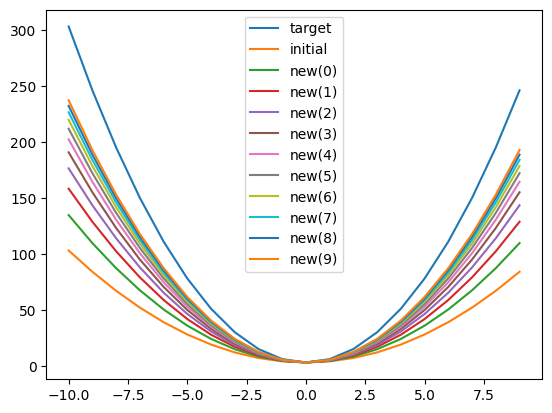

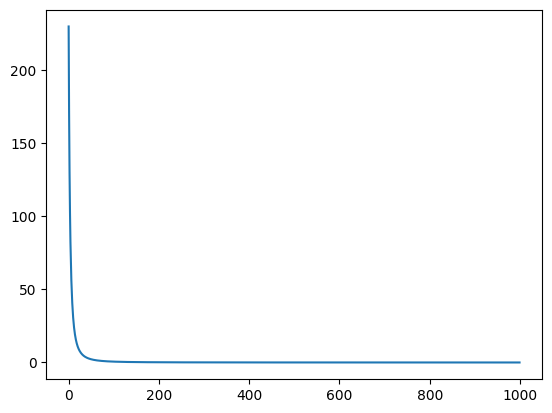

0.006098784880558039


In [32]:
# Lets check this gradient update on a simple fn
def local_scope():

    def plot_fn(f, label):
        xs = range(-10, 10, 1)
        ys = [f(x) for x in xs]
        plt.plot(xs, ys, label=label)
        
    def fn_given_w(w):
        return lambda x: w * x**2 + 3
    target_w = 3
    print(f"target_w={target_w}")
    target_fn = fn_given_w(target_w)
    plot_fn(target_fn, "target")

    init_w = 1.0
    print(f"init_w={init_w}")
    init_fn = fn_given_w(init_w)
    plot_fn(init_fn, "initial")    
    
    def loss_w(w, x):
        return (fn_given_w(target_w)(x) - fn_given_w(w)(x))**2

    # ugh ok this isn't so pretty. We won't be doing this analytically in the future
    def grad_w(w, x):
        return 2 * w * x**4 - 4 * (target_fn(x) + 3) * x**2 
    
    input = 3
    init_loss = loss_w(init_w, input)
    print(f"init_loss={init_loss}")

    new_w = init_w

    for i in range(10):
        grad = grad_w(new_w, input)
        print(f"grad={grad}")
        new_w = new_w - loss_w(new_w, input) / grad
        print(f"new_w({i})={new_w}")
        new_fn = fn_given_w(new_w)
        plot_fn(new_fn, f"new({i})")

    final_loss = loss_w(new_w, input)
    print(f"new_loss={final_loss}")

    plt.legend()
    plt.show()

    loss_plot_values = []
    def update(w):
        return w - loss_w(w, input) / grad_w(w, input)
    current_w = init_w
    for i in range(1000):
        current_w = update(current_w)
        loss_plot_values.append(loss_w(current_w, input))
    plt.plot(loss_plot_values)
    plt.show()
    print(loss_plot_values[-1])
    

local_scope()

This does seem to get there eventually though not super fast. We can come back to optimisers once we've managed to get the gradient for a NN since we'll need that anyway.

# Simple NN but with grad

In [109]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self) -> str:
        return f"Value(label={self.label}, data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def __gt__(self, other):
        return self.data > other.data
    
    def relu(self):
        if self.data > 0:
            return Value(self.data, (self, ), 'relu')
        else:
            return Value(0.0, (self, ), 'relu')
        
    def sq(self):
        return Value(self.data ** 2, (self, ), 'sq')

    
    def backprop(self):
        if self._op == '*':
            self._prev[0].grad += self._prev[1].data * self.grad
            self._prev[1].grad += self._prev[0].data * self.grad
            for child in self._prev:
                child.backprop()
        elif self._op == '+':
            self._prev[0].grad += 1.0 * self.grad
            self._prev[1].grad += 1.0 * self.grad
            for child in self._prev:
                child.backprop()
        elif self._op == '-':
            self._prev[0].grad += 1.0 * self.grad
            self._prev[1].grad += -1.0 * self.grad
            for child in self._prev:
                child.backprop()
        elif self._op == 'relu':
            if self.data > 0:
                self._prev[0].grad += 1.0 * self.grad
            else:
                self._prev[0].grad += 0.0
            for child in self._prev:
                child.backprop()
        elif self._op == 'sq':
            self._prev[0].grad += 2.0 * self._prev[0].data * self.grad
            for child in self._prev:
                child.backprop()
        else:
            return

def rand_vec(size):
    return [Value(random.uniform(-1, 1)) for _ in range(size)] # Now using a Value here

# Added this for the Perceptron forward pass
def sum_values(vec):
    s = Value(0)
    for v in vec:
        s += v
    return s

def relu(v):
    return v if v > Value(0) else Value(0) # Updated this to use Values too

class Perceptron:

    def __init__(self, weights, activation_fn='relu'):
        self.weights = weights
        self.acivation_fn = activation_fn

    def __repr__(self) -> str:
        return f"Perceptron({self.weights}, activation_fn={self.acivation_fn})"

    def forward(self, inputs) -> Value:
        if (len(inputs) != len(self.weights)):
            raise Exception("Number of inputs must match number of weights")
        result = sum_values(w*v for w, v in zip(self.weights, inputs))
        if (self.acivation_fn == 'relu'):
            result = result.relu()
        return result

class Layer:
    def __init__(self, input_size, num_node):
        self.input_size = input_size
        self.nodes = [Perceptron(rand_vec(input_size)) for _ in range(num_node)]

    def __repr__(self) -> str:
        return f"Layer(input_size={self.input_size}, num_node={len(self.nodes)})"

    def forward(self, inputs):
        if (len(inputs) != self.input_size):
            raise Exception("Number of inputs doesn't match layer expectation")
        return [node.forward(inputs) for node in self.nodes]
    
class FinalLayer:
    def __init__(self, input_size) -> None:
        self.input_size = input_size
        self.nodes = [Perceptron(rand_vec(input_size), '')]

    def __repr__(self) -> str:
        return f"FinalLayer(input_size={self.input_size})"

    def forward(self, inputs):
        if (len(inputs) != self.input_size):
            raise Exception("Number of inputs doesn't match layer expectation")
        return self.nodes[0].forward(inputs)

class SimpleNN:
    def __init__(self, input_size: int, layer_sizes: list[int]) -> None:
        self.input_size = input_size
        self.layers: list[Layer] = []
        last_layer_size = input_size
        for i in range(len(layer_sizes)):
            self.layers.append(Layer(last_layer_size, layer_sizes[i]))
            last_layer_size = layer_sizes[i]
        self.layers.append(FinalLayer(last_layer_size))

    def __repr__(self) -> str:
        return f"SimpleNN(input_size={self.input_size}, num_layers={len(self.layers)})"
    
    def forward(self, inputs):
        result = inputs
        for layer in self.layers:
            result = layer.forward(result)
        return result
    
    def backward(self, update_fn: Callable[[Value, float], Value], loss: Value):
        loss.grad = 1.0
        loss.backprop()
        for layer in self.layers:
            for node in layer.nodes:
                new_weights = []
                for weight in node.weights:
                    new_weights.append(update_fn(weight, loss.data))
                node.weights = new_weights
        
    
def loss(nn: SimpleNN, example) -> Value:
    return (nn.forward(example[0]) - example[1]) * (nn.forward(example[0]) - example[1]) # did this so we don't need to implement __pow__
    # return (nn.forward(example[0]) - example[1]).sq()

def test(nn: SimpleNN, examples):
    return sum([init_loss(nn, example) for example in examples]) / len(examples)

In [34]:
# Lets try this out on the simplest example possible. A one input identity function

training_data_size = 1000
training_data = [rand_vec(1) for _ in range(training_data_size)]
training_data = [(x, sum_values(x)) for x in training_data]
print(training_data[0])
print(sum_values(training_data[0][0]))

nn = SimpleNN(len(training_data[0][0]), [])

([Value(label=, data=0.40496045278188686)], Value(label=, data=0.40496045278188686))
Value(label=, data=0.40496045278188686)


In [35]:
# Here is the update rule based on completely removing the first order error based on a particular weight's gradient

def updated(w: Value, loss: float):
    if (w.grad != 0):
        return Value(w.data - loss / w.grad)
    return w

In [36]:
example_index = 0
print(f"Initial weight: {nn.layers[0].nodes[0].weights[0].data}")
result1 = loss(nn, training_data[example_index])
print(f"Initial result={result1.data} vs actual={training_data[example_index][1]}")
result1.backprop()
print(f"Initial gradient: {nn.layers[0].nodes[0].weights[0].grad}")
print(f"Updated weight: {updated(nn.layers[0].nodes[0].weights[0], loss(nn, training_data[example_index]).data).data}")

Initial weight: -0.5670595285936659
Initial result=0.4027135253182484 vs actual=Value(label=, data=0.40496045278188686)
Initial gradient: -0.2569867436240011
Updated weight: 0.9999999999999998


In [37]:
example_index = 1
print(f"Initial weight: {nn.layers[0].nodes[0].weights[0].data}")
result1 = loss(nn, training_data[example_index])
print(f"Initial result={result1.data} vs actual={training_data[example_index][1]}")
result1.backprop()
print(f"Initial gradient: {nn.layers[0].nodes[0].weights[0].grad}")
print(f"Updated weight: {updated(nn.layers[0].nodes[0].weights[0], loss(nn, training_data[example_index]).data).data}")

Initial weight: -0.5670595285936659
Initial result=2.4243710856486325 vs actual=Value(label=, data=0.9936056521824437)
Initial gradient: -1.5470829546752114
Updated weight: 1.0


So the training worked exactly in one step and only needs one example. Well it is a simple example I guess.

Let's try making it slightly more complicated

In [38]:
# This gives more than one gradient. They both should end up being 1.0, though

def generate_sum_fn_training_data(num_examples, input_size):
    training_data = [rand_vec(input_size) for _ in range(num_examples)]
    training_data = [(x, sum_values(x)) for x in training_data]
    return training_data

training_data = generate_sum_fn_training_data(10, 2)
print(training_data[0])
print(sum_values(training_data[0][0]))

nn = SimpleNN(len(training_data[0][0]), [])

([Value(label=, data=0.23183286114216828), Value(label=, data=0.2484289477620174)], Value(label=, data=0.4802618089041857))
Value(label=, data=0.4802618089041857)


In [39]:
example_index = 0
print(f"Initial weight: {nn.layers[0].nodes[0].weights[0].data}")
print(f"Initial weight: {nn.layers[0].nodes[0].weights[1].data}")
result1 = loss(nn, training_data[example_index])
print(f"Initial result={result1.data} vs actual={training_data[example_index][1]}")
result1.backprop()
print(f"Initial gradient: {nn.layers[0].nodes[0].weights[0].grad}")
print(f"Initial gradient: {nn.layers[0].nodes[0].weights[1].grad}")
print(f"Updated weight: {updated(nn.layers[0].nodes[0].weights[0], loss(nn, training_data[example_index]).data).data}")
print(f"Updated weight: {updated(nn.layers[0].nodes[0].weights[1], loss(nn, training_data[example_index]).data).data}")

Initial weight: -0.07387822413288125
Initial weight: -0.5121210587835912
Initial result=0.39014377922509796 vs actual=Value(label=, data=0.4802618089041857)
Initial gradient: -0.14480626047823975
Initial gradient: -0.1551724235413767
Updated weight: 2.6203684053747254
Updated weight: 2.002138693826809


In [40]:
# Lets try training (overfitting) on one example
training_steps = 10
for i in range(training_steps):
    current_loss = loss(nn, training_data[0])
    print(f"Loss after {i+1} training steps: {current_loss.data}")
    print(f"Current weight [0]: {nn.layers[0].nodes[0].weights[0].data}")
    print(f"Current weight [1]: {nn.layers[0].nodes[0].weights[1].data}")
    nn.backward(updated, current_loss)

Loss after 1 training steps: 0.39014377922509796
Current weight [0]: -0.07387822413288125
Current weight [1]: -0.5121210587835912
Loss after 2 training steps: 0.39014377922509824
Current weight [0]: 2.6203684053747254
Current weight [1]: 2.002138693826809
Loss after 3 training steps: 0.39014377922509835
Current weight [0]: -0.07387822413288214
Current weight [1]: -0.5121210587835918
Loss after 4 training steps: 0.39014377922509824
Current weight [0]: 2.6203684053747254
Current weight [1]: 2.0021386938268093
Loss after 5 training steps: 0.39014377922509824
Current weight [0]: -0.07387822413288214
Current weight [1]: -0.5121210587835914
Loss after 6 training steps: 0.39014377922509824
Current weight [0]: 2.6203684053747254
Current weight [1]: 2.0021386938268093
Loss after 7 training steps: 0.39014377922509824
Current weight [0]: -0.07387822413288214
Current weight [1]: -0.5121210587835914
Loss after 8 training steps: 0.39014377922509824
Current weight [0]: 2.6203684053747254
Current weig

Really interesting. So we see the weights get caught in this oscillation. It must be because our update rule kinda sucks - works fine for just one weight but is all over the place for even two.

Let's investigate using Stochastic Gradient Descent.

# Stochastic Gradient Descent

It's all in the name, really. We're going to try to descent the loss function by using the gradients of function parameters. Why stochastic? Yeah actually not sure about that.

All I remember is that you apply a learning rate to only remove part of the error.

Loss after 1 training steps: 0.15058071353001523
Current weight [0]: 0.4872003969437113
Current weight [1]: -0.0834627430561421
Loss after 11 training steps: 0.0017360774280779745
Current weight [0]: 1.2342494653783453
Current weight [1]: 0.6136803415521005
Loss after 21 training steps: 2.0015610004936433e-05
Current weight [0]: 1.3144632483141956
Current weight [1]: 0.6885355102777246
Loss after 31 training steps: 2.307642720251819e-07
Current weight [0]: 1.3230761376741438
Current weight [1]: 0.6965730228180526
Loss after 41 training steps: 2.6605309171282887e-09
Current weight [0]: 1.3240009396272698
Current weight [1]: 0.6974360441556
Loss after 51 training steps: 3.0673833080477e-11
Current weight [0]: 1.3241002394808685
Current weight [1]: 0.6975287103661132
Loss after 61 training steps: 3.5364521783109314e-13
Current weight [0]: 1.324110901721461
Current weight [1]: 0.6975386603247032
Loss after 71 training steps: 4.077251759033694e-15
Current weight [0]: 1.3241120465708272
Curr

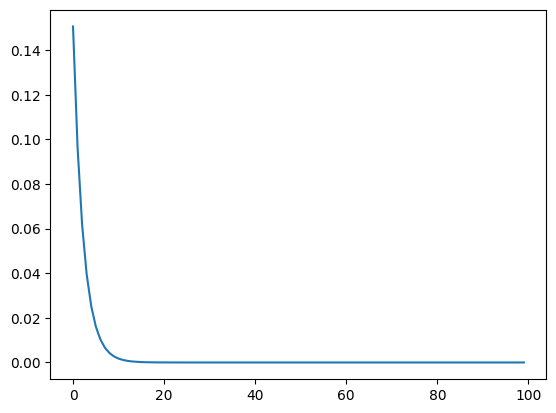

In [41]:
learning_rate = 0.1

def update_fn(learning_rate: float):
    def update(w: Value, loss: float):
        if (w.grad != 0):
            return Value(w.data - learning_rate * loss / w.grad)
        return w
    return update

nn = SimpleNN(len(training_data[0][0]), [])

training_steps = 100
losses = []
for i in range(training_steps):
    current_loss = loss(nn, training_data[0])
    losses.append(current_loss.data)
    if i % 10 == 0:
        print(f"Loss after {i+1} training steps: {current_loss.data}")
        print(f"Current weight [0]: {nn.layers[0].nodes[0].weights[0].data}")
        print(f"Current weight [1]: {nn.layers[0].nodes[0].weights[1].data}")
    nn.backward(update_fn(learning_rate), current_loss)
                
plt.plot(losses)

Well that immediately worked a whole lot better.

For one example at least. The weights aren't generally any good because we've only trained on that one example, though.

In [42]:
for example in training_data:
    print(loss(nn, example).data)

6.248365382101618e-21
0.03397529879864868
0.2923203204830262
0.0017963603971393248
0.3115863788978538
0.001618068183763933
0.04418771782764847
0.3281689401108624
0.004926971687903965
0.016475142166252548


Now the stochastic part comes in - we sample from the training data to calculate a gradient and use that to update the weights

Loss after 1 training steps: 0.0009799905185089585
Current weight [0]: -0.09462834186475319
Loss after 11 training steps: 0.05149928304459917
Current weight [0]: 0.6183266972693483
Loss after 21 training steps: 0.002499270348645364
Current weight [0]: 0.8669187481760613
Loss after 31 training steps: 0.0006125658676621117
Current weight [0]: 0.9535974367074737
Loss after 41 training steps: 7.686028859627767e-05
Current weight [0]: 0.9838204266145204
Loss after 51 training steps: 2.6029919068170445e-08
Current weight [0]: 0.9943585315904675
Loss after 61 training steps: 9.422858125832601e-07
Current weight [0]: 0.9980329415950908
Loss after 71 training steps: 1.381187302619139e-07
Current weight [0]: 0.9993141291437907
Loss after 81 training steps: 1.6792013161530672e-08
Current weight [0]: 0.9997608516197469
Loss after 91 training steps: 8.091809094505022e-09
Current weight [0]: 0.9999166141158209


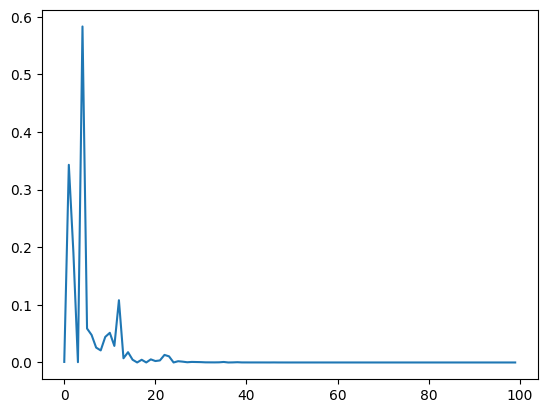

In [43]:
training_data = generate_sum_fn_training_data(10, 1)
nn = SimpleNN(len(training_data[0][0]), [])

learning_rate = 0.1

training_steps = 100
losses = []
for step in range(training_steps):
    example = random.choice(training_data) # this is apparently important to avoid cycles in the updates
    current_loss = loss(nn, example)
    nn.backward(update_fn(learning_rate), current_loss)
    losses.append(current_loss.data)
        
    if step % (training_steps // 10) == 0:
        print(f"Loss after {step+1} training steps: {losses[-1]}")
        print(f"Current weight [0]: {nn.layers[0].nodes[0].weights[0].data}")
    
plt.plot(losses)

In [114]:
# set up the experiement so we can play with the number of nodes
import statistics

def fit_sum_experiment(input_size, learning_rate, training_steps):
    training_data = generate_sum_fn_training_data(1000, input_size)
    nn = SimpleNN(len(training_data[0][0]), [])

    losses = []
    for step in range(training_steps):
        example = random.choice(training_data)
        current_loss = loss(nn, example)
        nn.backward(update_fn(learning_rate), current_loss)
        if step % (training_steps // 100) == 0:
            losses.append(current_loss.data)
            
        if step % (training_steps // 10) == 0:
            print(f"Loss after {step+1} training steps: {losses[-1]}")
            print(f"Std dev of weights: {statistics.stdev(map(lambda x: x.data, nn.layers[0].nodes[0].weights))}")
            for i, weight in enumerate(nn.layers[0].nodes[0].weights):
                print(f"Current weight [{i}]: {weight}")
        
    plt.plot(losses)

Loss after 1 training steps: 2.2029510853861347
Std dev of weights: 0.5084296416387053
Current weight [0]: Value(label=, data=0.3460946877477883)
Current weight [1]: Value(label=, data=-0.26726896183985915)
Current weight [2]: Value(label=, data=-0.7549414024087322)
Current weight [3]: Value(label=, data=-0.6968643013051814)
Loss after 100001 training steps: 0.1343638226449333
Std dev of weights: 0.4755842442543584
Current weight [0]: Value(label=, data=0.393146751905013)
Current weight [1]: Value(label=, data=-0.18911014776333898)
Current weight [2]: Value(label=, data=-0.6347819327323699)
Current weight [3]: Value(label=, data=-0.5864710488487429)
Loss after 200001 training steps: 0.21024265381524324
Std dev of weights: 0.44493363875080905
Current weight [0]: Value(label=, data=0.436884156014993)
Current weight [1]: Value(label=, data=-0.11571831465834942)
Current weight [2]: Value(label=, data=-0.5230380211226852)
Current weight [3]: Value(label=, data=-0.4830706181440852)
Loss afte

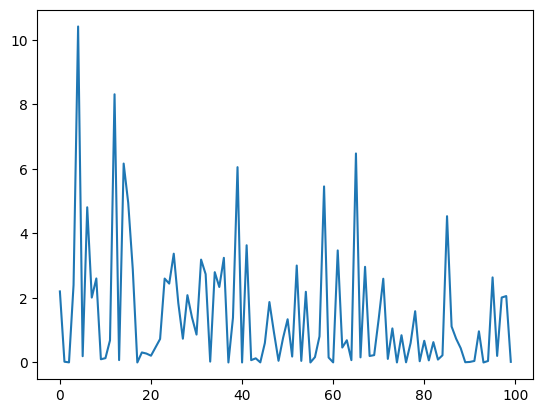

In [115]:
fit_sum_experiment(4, 0.000001, 1000000)

That really seems to take a long time and is quite sensitive to our choice of learning rate - if it is too big things just blow up.

Perhaps using mini-batches will help?

Or perhaps it is because we are including the loss size in our update function... That might have something of a squaring effect that could be blowing up the errors...

In [118]:
def update_fn(learning_rate: float):
    def update(w: Value, loss: float):
        return Value(w.data - learning_rate * w.grad)
    return update

Loss after 1 training steps: 23.290262238625097
Std dev of weights: 0.6593289775290949
Current weight [0]: Value(label=, data=-0.5804238504055612)
Current weight [1]: Value(label=, data=-0.3086177444402913)
Current weight [2]: Value(label=, data=-0.42877333665210277)
Current weight [3]: Value(label=, data=0.8773030286909058)
Current weight [4]: Value(label=, data=0.4083566445526001)
Current weight [5]: Value(label=, data=-0.8389213681602719)
Current weight [6]: Value(label=, data=-0.26029398447835767)
Current weight [7]: Value(label=, data=0.8668159884526572)
Current weight [8]: Value(label=, data=-0.3336358531530227)
Current weight [9]: Value(label=, data=0.8558307123253139)
Loss after 101 training steps: 0.32581214083312676
Std dev of weights: 0.32100450889213605
Current weight [0]: Value(label=, data=0.2199514869102161)
Current weight [1]: Value(label=, data=0.1946855196976564)
Current weight [2]: Value(label=, data=0.3080514576443522)
Current weight [3]: Value(label=, data=0.916452

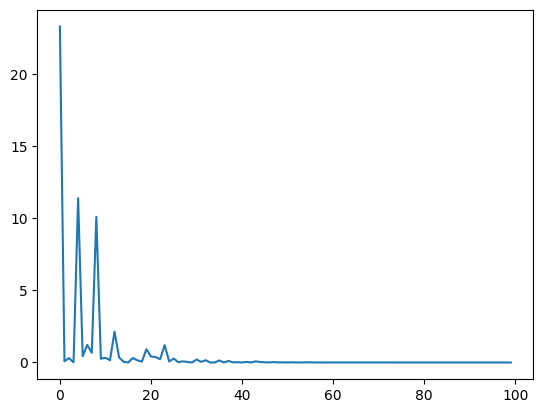

In [119]:
fit_sum_experiment(10, 0.01, 1000)

Lol well that works a fuck ton better. Ok so I guess that is probably how you do SGD

## On to a multi layer NN then!
We're now going to be backprop-ing through our activation function. Let's just check that we are sure we know that this works...

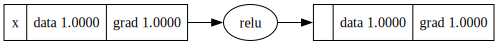

In [49]:
x = Value(1, label='x')
f = x.relu()
f.backprop()
draw_dot(f)

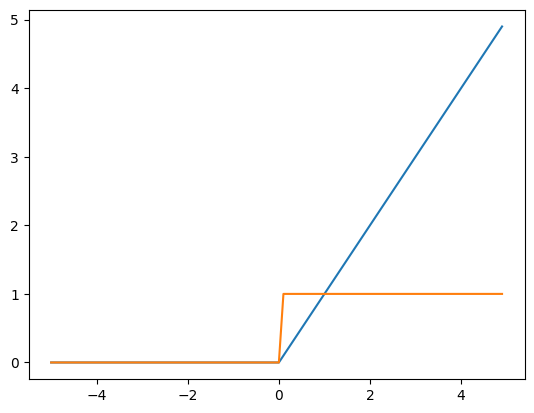

In [50]:
def f_and_df(x_data):
    x = Value(x_data, label='x')
    f = x.relu()
    f.backprop()
    return f.data, x.grad

xs = np.arange(-5, 5, 0.1)
f_and_dfs = [f_and_df(x) for x in xs]
fs = [p[0] for p in f_and_dfs]
dfs = [p[1] for p in f_and_dfs]
plt.plot(xs, fs)
plt.plot(xs, dfs)

In [111]:
# Lets now run these experiments with a multi layered nn

def fit_sum_experiment_2(input_size, learning_rate, training_steps, training_data_size, layer_sizes: list[int]):
    training_data = generate_sum_fn_training_data(training_data_size, input_size)
    nn = SimpleNN(len(training_data[0][0]), layer_sizes)

    losses = []
    for step in range(training_steps):
        example = random.choice(training_data)
        current_loss = loss(nn, example)
        nn.backward(update_fn(learning_rate), current_loss)
        if step % (training_steps // 100) == 0:
            losses.append(current_loss.data)
            
        if step % (training_steps // 10) == 0:
            print(f"Loss after {step+1} training steps: {losses[-1]}")
            # print(f"Std dev of weights: {statistics.stdev(map(lambda x: x.data, nn.layers[0].nodes[0].weights))}")
            for i, weight in enumerate(nn.layers[0].nodes[0].weights):
                print(f"Current weight [{i}]: {weight}")
        
    plt.plot(losses)

Loss after 1 training steps: 14.10390501399207
Current weight [0]: Value(label=, data=0.12780445091653697)
Current weight [1]: Value(label=, data=-0.3565006687554806)
Current weight [2]: Value(label=, data=0.9063955150261421)
Current weight [3]: Value(label=, data=0.679828321434824)
Current weight [4]: Value(label=, data=0.051749665210417004)
Current weight [5]: Value(label=, data=-0.43149514793229315)
Current weight [6]: Value(label=, data=0.44513028048190983)
Current weight [7]: Value(label=, data=-0.10032237310395913)
Current weight [8]: Value(label=, data=0.12543832340334402)
Current weight [9]: Value(label=, data=0.1681480452941391)
Loss after 101 training steps: 0.0372750711286786
Current weight [0]: Value(label=, data=0.37487834496146133)
Current weight [1]: Value(label=, data=-0.2321127067660661)
Current weight [2]: Value(label=, data=0.9945307485224851)
Current weight [3]: Value(label=, data=0.9058352423786048)
Current weight [4]: Value(label=, data=0.219931829160741)
Current 

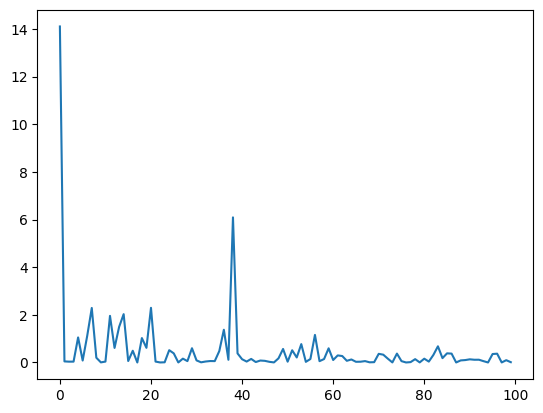

In [122]:
fit_sum_experiment_2(10, 0.01, 1000, 10000, [10])

That is going in the wrong direction...

Let's check the gradient update part with just one node.

loss: Value(label=, data=0.25)
gradient: -1.0
updated weight: 0.6


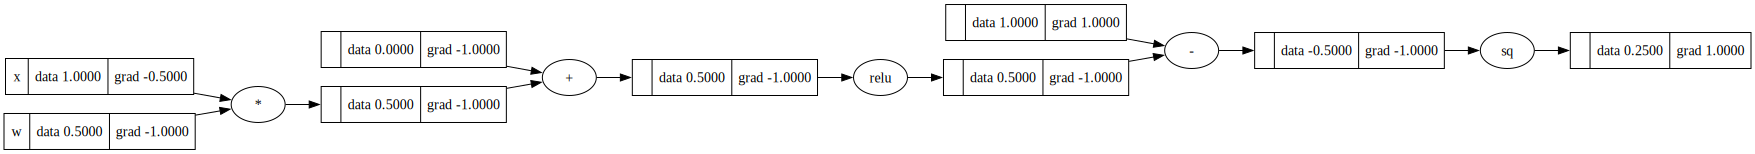

In [98]:
example = [[Value(1, label='x')], Value(1)]
p = Perceptron([Value(0.5, label='w')])

result = p.forward(example[0])
this_loss = (result - example[1]).sq()
print(f"loss: {this_loss}")
this_loss.grad = 1.0
this_loss.backprop()
print(f"gradient: {p.weights[0].grad}")
p.weights[0] = Value(p.weights[0].data - p.weights[0].grad * 0.1, label='w')
print(f"updated weight: {p.weights[0].data}")

draw_dot(this_loss)

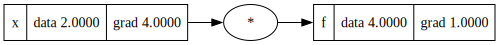

In [93]:
x = Value(2, label='x')
f = x * x; f.label = 'f'
f.grad = 1.0
f.backprop()
draw_dot(f)

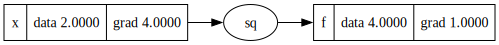

In [94]:
x = Value(2, label='x')
f = x.sq(); f.label = 'f'
f.grad = 1.0
f.backprop()
draw_dot(f)

# Additional Thoughts and Notes

## Why not use numerical differentiation?
I mean autograd is super cool but does it not work to do the bump and re-eval?

Potential answer - you need to evaluate the entire path forward in the graph after bumping each weight. So the number of nn forward eval (which must scale at best linearly with the number of weights) would scale at n or maybe log n. Seems like it's going to be inefficient.

Should still work though I think.

## Why not use a step activation function? Not continuous but relu also isn't differentiable at 0

## How do we do autodiff on nodes that are repeated?
For e.g. if our graph is $f = x.x$ instead of $f = x^2$

It seems like adding the grads works but I'm not completely sure why.